# U-Net | Train Model and Make Submission File

This is a tutorial of [OpenPack Challenge 2022](https://open-pack.github.io/challenge2022/). 
In this notebook, we will build the U-Net, one of the basic architecture for segmentation, with the acceleration data from the left wrist (atr01). This notebook also shows how to make submission file (`submission.json`) for OpenPack Challenge 2022. In fact, the performance of this U-Net is poor. Please enjoy finding a better architecture and parameters.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-pack/openpack-torch/blob/main/examples/unet/notebooks/U-Net_Train-a-Model-and-Make-Submission-File.ipynb)

## [0] Inital Setup

### 0-1: Download Code and Install `openpack-torch` 
NOTE: You can also install `openpack-torch` from PyPI with `pip install openpack-torch`.

In [ ]:
! cd /content && git clone https://github.com/open-pack/openpack-torch.git

In [1]:
! cd /content/openpack-torch/ && pip install .

Processing /content/openpack-torch
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for openpack-torch: filename=openpack_torch-0.4.0-py3-none-any.whl size=19653 sha256=7a879d837ea83a02703aa0826c4d4fb1001241553259d4eea09d22da99cbf6ba
  Stored in directory: /root/.cache/pip/wheels/3c/41/d3/f3da9cc23f0fe3895867143cff021a2da847c6ed2c7f33f269
Successfully built openpack-torch
  Attempting uninstall: openpack-torch
    Found existing installation: openpack-torch 0.3.0
    Uninstalling openpack-torch-0.3.0:
      Successfully uninstalled openpack-torch-0.3.0


### 0-2: Download Dataset to Your Google Drive
Download OpenPack dataset to your google drive (`/MyDrive/Colab Notebooks/openpack/data`) and make a symlink to `/content/data`. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

If you have already downloaded the data set, skip this step.

In [ ]:
! mkdir -p "/content/drive/MyDrive/Colab Notebooks/openpack/data/datasets"
! optk-download -d "/content/drive/MyDrive/Colab Notebooks/openpack/data/datasets" -v v0.2.1 -s atr-qags,openpack-operations
! ln -s "/content/drive/MyDrive/Colab Notebooks/openpack/data/" "/content/data"

### 0-3: Import Modules

In [1]:
import os
import shutil
import logging
from pathlib import Path
from typing import Dict, Optional


import hydra
import numpy as np
import openpack_toolkit as optk
import openpack_torch as optorch
import pandas as pd
import pytorch_lightning as pl
import torch
from scipy.special import softmax

import matplotlib.pyplot as plt
import seaborn as sns
from omegaconf import DictConfig, OmegaConf

from openpack_toolkit import OPENPACK_OPERATIONS
from openpack_toolkit.codalab.operation_segmentation import (
    construct_submission_dict, eval_operation_segmentation_wrapper,
    make_submission_zipfile)

sns.set("notebook", "whitegrid")

/opt/conda/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


### 0-4: Setup Logger

In [2]:
_ = optk.utils.notebook.setup_root_logger()
logger = logging.getLogger(__name__)

logger.debug("debug")
logger.info("info")
logger.warning("warning")

2022-09-28 22:23:52 | INFO | __main__ | info
2022-09-28 22:23:52 | WARNING | __main__ | warning


### 0-5: Set Random Seed

In machine learning, a lot of random variables are generated and it affect to model's performance.
By resetting a random seed before each run, you can improve reproducibility. 

In [3]:
optorch.utils.reset_seed(seed=0)

2022-09-28 22:23:52 | INFO | openpack_torch.utils.random | Reset Seeds: python=0, numpy=0, Pytorch (cpu=0, cuda=0)


## [1] Load Config File

### 1-1: Overview of Config Files
Thare are a lot of parameters that are needed to train deep learning models. Managing these parameters is a laborious task.
Here are some useful tools to ease this burden. [hydra](https://hydra.cc/) is a framework for elegantly configurein complex application, and also you can use it to manage parameters.
To update default parameters, please update YAML files in [configs](https://github.com/open-pack/openpack-torch/tree/main/examples/unet/configs).
We will show you some examples here, but when you want to utilse yaml files, please refere to other tutorials.

#### Ex.1: Change Training Parameters

For example, when you want to change default `batch_size`, edit [operation-segmentation.yaml](https://github.com/open-pack/openpack-torch/blob/main/examples/unet/configs/operation-segmentation.yaml) as follows.

```yaml
train:
  num_workers: 3
  batch_size: 128 # Updated (original value = 64)
  epochs: 100
```

#### Ex.2: Change Input Modality

An another example is to add IMU sensors at left&right arm (atr03, atr04).
You can change it by editing [atr-acc-wrists.yaml](https://github.com/open-pack/openpack-torch/blob/main/examples/unet/configs/dataset/stream/atr-acc-wrists.yaml)


```yaml
defaults:
  - atr-qags
  - _self_
name: atr-acc-wrists
super_stream: atr-qags
devices:
- atr01
- atr02 # Add
- atr03 # Add 
- atr04 # Add
acc: true
gyro: false
quat: false
```

### 1-2: Register Configs to Hydra in `openpack-torch`
First, register OpenPaack official configs to hydra.

In [4]:
optorch.configs.register_configs()

### 1-3: Load Custom Configs
Load configuration files in [/content/openpack-torch/examples/unet/configs](https://github.com/open-pack/openpack-torch/blob/main/examples/unet/configs/operation-segmentation.yaml).
In this notebook, we will copy YAML files to the current directory and load default parameters from there.
You may want to change some default parameters, please save config files into your Google Drive and edit them.
For temporal changes such as learning rate, we can change them by `overrides` param in `hydra.compose()`. 

In [5]:
! cp -r /content/openpack-torch/examples/unet/configs /content/

In [6]:
overrides = [
    "mode=train",
    "issue=I01-EXP1-V1-nb", # subdirectry for logging
    
    # -- debug --
    # If true, some training parameters (e.g., bach size, epochs) are switched to debug mode setting written in `train.debug.XXX`.
    "debug=false",
    
    # -- path.logdir.rootdir --
    # path to write training logs and resutls.
    # If you want to keep logs, please use Google Drive (i.e., `/content/data/XXX` (symling to Google Drive), `/content/drive/XXX`)
    "path.logdir.rootdir=/content/logs/${dataset.name}/${model.name}/${issue}"
    
    # "hydra/job_logging=custom",
    # "hydra/hydra_logging=disabled"
]

with hydra.initialize_config_dir(version_base=None, config_dir="/content/configs"):
    cfg = hydra.compose(
        config_name="unet.yaml",
        overrides=overrides,
    )
    
# -- Target Acticity Class --
cfg.dataset.annotation.activity_sets = dict() # Remove this attribute just for the simpler visualization.

# -- Data Split --
# Change Train/Val/Test/Submission set to submit for Development Phase.
# Please comment out the following block when you want to train on the main set.
cfg.dataset.split = optk.configs.datasets.splits.DEBUG_SPLIT

# (default value)
# cfg.dataset.split = optk.configs.datasets.splits.OPENPACK_CHALLENGE_2022_SPLIT

In [7]:
print(OmegaConf.to_yaml(cfg))

dataset:
  annotation:
    conf_type: ANNOT_FILE
    name: activity-1s
    version: ''
    path:
      dir: ${path.openpack.rootdir}/${user.name}/annotation/activity-1s/
      fname: ${session}.csv
    file_format: null
    classes: ???
    activity_sets: {}
  stream:
    schema: ImuConfig
    name: atr-acc-left-wrist
    description: null
    super_stream: atr-qags
    path:
      dir: ${path.openpack.rootdir}/${user.name}/atr/${device}
      fname: ${session}.csv
    file_format: null
    frame_rate: 30
    devices:
    - atr02
    acc: true
    gyro: false
    quat: false
  split:
    name: debug
    train:
    - - U0102
      - S0100
    - - U0102
      - S0200
    - - U0102
      - S0300
    val:
    - - U0102
      - S0400
    test:
    - - U0102
      - S0500
    submission:
    - - U0102
      - S0500
  classes:
    classes:
    - id: 100
      name: Picking
      is_ignore: false
    - id: 200
      name: Relocate Item Label
      is_ignore: false
    - id: 300
      name: Ass

## [2] Define Utilities (Pytorch Lightning Modules)

### 2-1: DataModule

Override `dataset_class` with `optorch.data.OpenPackBaseDataModule` to use IMU dataset.
When you implement custom dataset, set the dataset class to `dataset_class`. 
IMU dataset is defined in [here](https://github.com/open-pack/openpack-torch/blob/main/openpack_torch/data/datasets.py).
Paramters to initialize the dataset class should be prepared in `get_kwargs_form_datasets()` method.
The dataset class is initialized with`kwargs`, an output of `get_kwargs_form_datasets()`, as follows. 

```python
# https://github.com/open-pack/openpack-torch/blob/6c6933e24c7c3311e582ebf3aac1a659467be0fb/openpack_torch/data/datamodule.py#L91
self.op_train = self.dataset_class(self.cfg, split.train, **kwargs)
```

In [8]:
class OpenPackImuDataModule(optorch.data.OpenPackBaseDataModule):
    dataset_class = optorch.data.datasets.OpenPackImu

    def get_kwargs_for_datasets(self, stage: Optional[str] = None) -> Dict:
        kwargs = {
            "window": self.cfg.train.window,
            "debug": self.cfg.debug,
        }
        return kwargs

### 2-2: Lightning Module

In the `init_model()` method, you can initialize your model.

In the `init_criterion()` method, you can register your custom loss function.
But make sure that ignore classes are excluded from evaluation process.
For `torch.nn.CrossEntropyLoss`, you can use `ignore_class` parameter.

In [9]:
class UNetLM(optorch.lightning.BaseLightningModule):

    def init_model(self, cfg: DictConfig) -> torch.nn.Module:
        dstream_conf = self.cfg.dataset.stream
        in_ch = len(dstream_conf.devices) * 3

        # Edit here to use your custom model!
        model = optorch.models.imu.UNet(
            in_ch,
            len(OPENPACK_OPERATIONS),
            depth=cfg.model.depth,
        )
        return model
    
    
    def init_criterion(self, cfg: DictConfig):
        ignore_cls = [(i, c) for i, c in enumerate(cfg.dataset.classes.classes) if c.is_ignore]
        
        criterion = torch.nn.CrossEntropyLoss(
            ignore_index=ignore_cls[-1][0]
        )
        return criterion

    def training_step(self, batch: Dict, batch_idx: int) -> Dict:
        x = batch["x"].to(device=self.device, dtype=torch.float)
        t = batch["t"].to(device=self.device, dtype=torch.long)
        y_hat = self(x).squeeze(3)

        loss = self.criterion(y_hat, t)
        acc = self.calc_accuracy(y_hat, t)
        return {"loss": loss, "acc": acc}

    def test_step(self, batch: Dict, batch_idx: int) -> Dict:
        x = batch["x"].to(device=self.device, dtype=torch.float)
        t = batch["t"].to(device=self.device, dtype=torch.long)
        ts_unix = batch["ts"]

        y_hat = self(x).squeeze(3)

        outputs = dict(t=t, y=y_hat, unixtime=ts_unix)
        return outputs


## [3] Train U-Net

### 3-1: Initialize U-Net Model and DataLoader.

In [10]:
device = torch.device("cuda")
logdir = Path(cfg.path.logdir.rootdir)
logger.debug(f"logdir = {logdir}")

datamodule = OpenPackImuDataModule(cfg)
plmodel = UNetLM(cfg).to(dtype=torch.float, device=device)

In [11]:
plmodel

UNetLM(
  (net): UNet(
    (inc): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (encoder): UNetEncoder(
      (conv_blocks): ModuleList(
        (0): DownBlock(
          (double_conv): Sequential(
            (0): Conv2d(32, 32, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
            (3): Conv2d(32, 32, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
            (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (5): ReLU()
          )
          (pool): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
        )
        (1): DownBlock(
          (double_conv): Sequential(
            (0): Conv2d(32, 64, kernel_size=(3,

### 3-2: Initialize Trainer

In [12]:
num_epoch = cfg.train.debug.epochs if cfg.debug else cfg.train.epochs
# num_epoch = 20 # NOTE: Set epochs manually for debugging

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    save_top_k=0,
    save_last=True,
    monitor=None,
)

trainer = pl.Trainer(
    gpus=[0],
    max_epochs=num_epoch,
    logger=False,  # disable logging module
    default_root_dir=logdir,
    enable_progress_bar=False,  # disable progress bar
    enable_checkpointing=True,
    callbacks=[checkpoint_callback],
)
logger.debug(f"logdir = {logdir}")

/opt/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### 3-3: Start training!

In [13]:
logger.info(f"Start training for {num_epoch} epochs.")
trainer.fit(plmodel, datamodule)
logger.info("Finish training!")

2022-09-28 22:23:58 | INFO | __main__ | Start training for 100 epochs.
2022-09-28 22:23:59 | WARNING | openpack_torch.data.datasets | No preprocessing is applied.
2022-09-28 22:23:59 | WARNING | openpack_torch.data.datasets | No preprocessing is applied.
2022-09-28 22:23:59 | INFO | openpack_torch.data.datamodule | dataset[train]: OpenPackImu(index=129, num_sequence=3, submission=False)
2022-09-28 22:23:59 | INFO | openpack_torch.data.datamodule | dataset[val]: {'U0102-S0400': <openpack_torch.data.datasets.OpenPackImu object at 0x7fe5eb10aee0>}
2022-09-28 22:23:59 | INFO | openpack_torch.data.datamodule | dataset[test]: None
2022-09-28 22:23:59 | INFO | openpack_torch.data.datamodule | dataset[submission]: None
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | net       | UNet             | 11.5 M
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
11.5 M    Trai

### 3-4: Plot Training Curve

Training logs are stored in `plmodel.log` (dict). Let's visualize training curves for training and validation set.

In [14]:
df = pd.concat([
    pd.DataFrame(plmodel.log_dict["train"]),
    pd.DataFrame(plmodel.log_dict["val"]),
],axis=1,)
df.index.name = "epoch"

In [15]:
df.head()

,train/loss,train/acc,val/loss,val/acc
epoch,,,,
0,2.419266,0.107531,2.419502,0.070543
1,2.424838,0.123307,2.417658,0.070443
2,2.424841,0.144114,2.413230,0.070179
3,2.399221,0.153155,2.409214,0.065340
4,2.380948,0.147951,2.403244,0.057825


Training Log

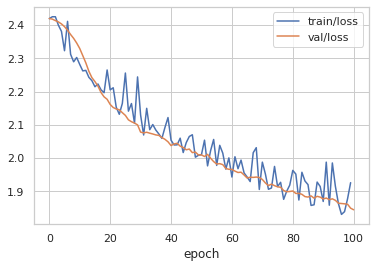

In [16]:
df[["train/loss", "val/loss"]].plot()
plt.show()

Test Log

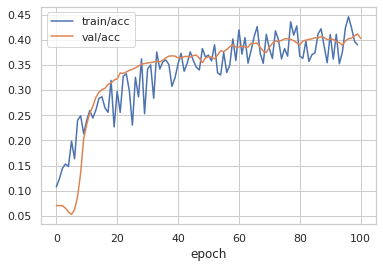

In [17]:
df[["train/acc", "val/acc"]].plot()
plt.show()

## [4] Test

Evaluation function is defined in `optk.codalab.eval_operation_segmentation_wrapper()`. This function takes dict as the 1st argument and prediction (`y`), groundtruth (`t_idx`; activity class index) and corresponding unixtime (`unixtime`) must be included in the dict object. Each sequence should be stored in the different entries with a key `{user}-{session}` (e.g., `U0107-S0100`).

```python
outputs = {
    "U0102-S0100": {
        "t_idx": [0, 0, ...], # groundtruth (class index)
        "y": [
            [
                [0., 0., ...],
                [0., 0., ...],
                [1., 1., ...],
            ],
        ], # prediction. shape=(B,N_CLASSES,T), dtype=float
        "unixtiume": [634885794000, 1634885794200, ...], # unixtime
    },
    "U0102-S0200": {
        "t_idx": [...], 
        "y": [...],
        "unixtiume": [...],
    },
    ...
}
```

### 4-1: Get prediction results for each sequences and build result dict.

NOTE: In `DEBUG_SPLIT`, U0102-S0500 is set to both the test set and the submission set for debugging purpose.

In [18]:
datamodule.setup("test")
dataloaders = datamodule.test_dataloader()
split = cfg.dataset.split.test


outputs = dict()
for i, dataloader in enumerate(dataloaders):
    user, session = split[i]
    logger.info(f"test on {user}-{session}")

    trainer.test(plmodel, dataloader)

    # save model outputs
    pred_dir = Path(
        cfg.path.logdir.predict.format(user=user, session=session)
    )
    pred_dir.mkdir(parents=True, exist_ok=True)

    for key, arr in plmodel.test_results.items():
        path = Path(pred_dir, f"{key}.npy")
        np.save(path, arr)
        logger.info(f"save {key}[shape={arr.shape}] to {path}")

    outputs[f"{user}-{session}"] = {
        "t_idx": plmodel.test_results.get("t"),
        "y": plmodel.test_results.get("y"),
        "unixtime": plmodel.test_results.get("unixtime"),
    }

2022-09-28 22:26:12 | WARNING | openpack_torch.data.datasets | No preprocessing is applied.
2022-09-28 22:26:12 | INFO | openpack_torch.data.datamodule | dataset[train]: None
2022-09-28 22:26:12 | INFO | openpack_torch.data.datamodule | dataset[val]: None
2022-09-28 22:26:12 | INFO | openpack_torch.data.datamodule | dataset[test]: {'U0102-S0500': <openpack_torch.data.datasets.OpenPackImu object at 0x7fe5eb013c70>}
2022-09-28 22:26:12 | INFO | openpack_torch.data.datamodule | dataset[submission]: None
2022-09-28 22:26:12 | INFO | __main__ | test on U0102-S0500
2022-09-28 22:26:12 | WARNING | openpack_torch.data.datasets | No preprocessing is applied.
2022-09-28 22:26:12 | INFO | openpack_torch.data.datamodule | dataset[train]: None
2022-09-28 22:26:12 | INFO | openpack_torch.data.datamodule | dataset[val]: None
2022-09-28 22:26:12 | INFO | openpack_torch.data.datamodule | dataset[test]: {'U0102-S0500': <openpack_torch.data.datasets.OpenPackImu object at 0x7fe5eb0af460>}
2022-09-28 22:26

### 4-2: Evaluate

In [19]:
# compute performance summary
df_summary = eval_operation_segmentation_wrapper(
    cfg, outputs, OPENPACK_OPERATIONS,
)

In [20]:
df_summary[df_summary["key"]=="all"]

,name,id,precision,recall,f1,support,key
12,avg/macro,-1,0.335504,0.302580,0.267704,None,all
13,avg/weighted,-1,0.353488,0.345225,0.301331,None,all
14,Picking,100,0.297872,0.502994,0.374165,167,all
15,Relocate Item Label,200,0.333333,0.093023,0.145455,387,all
16,Assemble Box,300,0.505703,0.519531,0.512524,256,all
17,Insert Items,400,0.322581,0.070423,0.115607,142,all
18,Close Box,500,0.242647,0.372881,0.293987,177,all
19,Attach Box Label,600,0.166667,0.062500,0.090909,64,all
20,Scan Label,700,0.386364,0.756849,0.511574,292,all
21,Attach Shipping Label,800,0.571429,0.040000,0.074766,100,all


### 4-3: Visualize Model Output

The model's outputs can be transformed into probability by applying `softmax()` function.
Here, let's visualize confidence scores as heatmap.

NOTE: Evaluation is done in 1 Hz, but we visualize the output sample by sample.

In [21]:
def plot_timeline(samples, t_idx, y_softmax, title_prefix=""):
    fig, ax0 = plt.subplots(1, 1, figsize=(20, 4))

    prob = y_softmax[slice(*samples)].transpose(1, 0, 2).reshape(11, -1)
    gt = t_idx[slice(*samples)].ravel()
    pred = prob.argmax(axis=0)
    
    print(f"prob={prob.shape} pred={pred.shape}, gt={gt.shape}")
    seq_len = prob.shape[1]

    # -- Prob --
    sns.heatmap(
        prob,
        vmin=0, vmax=1.0, cmap="viridis", cbar=False,
        ax=ax0
    )

    # -- Ground Truth --
    x = np.arange(seq_len)
    ax0.plot(
        x, gt + 0.5, label="ground truth",
        linewidth=5, color="C3", 
    )
    # ax0.plot(
    #     x, pred + 0.5, label="pred",
    #     linewidth=1, color="C1", alpha=0.5,
    # )

    # -- Style --
    ax0.invert_yaxis()
    xticks = np.arange(0, seq_len, 30 * 30)
    xticks_minor = np.arange(0, seq_len, 30 * 10)
    ax0.set_xticks(xticks)
    ax0.set_xticklabels(xticks // 30 + samples[0] * 60, rotation=0)
    ax0.set_xticks(xticks_minor, minor=True)

    ax0.set_yticks(np.arange(11) + 0.5)
    ax0.set_yticklabels(np.arange(11), rotation=0)
    
    
    ax0.set_xlabel("Time [s]", fontsize="large", fontweight="bold")
    ax0.set_ylabel("Class Index", fontsize="large", fontweight="bold")
    ax0.set_title(f"{title_prefix} | {samples[0]}min ~ {samples[1]}min", fontsize="xx-large", fontweight="bold")
    ax0.grid(True, which="minor", linestyle=":")
    ax0.legend(loc="upper right")

    fig.tight_layout()
    return fig


In [22]:
key = "U0102-S0500"

unixtimes = outputs[key]["unixtime"] 
t_idx = outputs[key]["t_idx"]
y = outputs[key]["y"]
y_softmax = softmax(y, axis=1)
print(f"unixtimes={unixtimes.shape}, t_idx={t_idx.shape}, y={y.shape}, y_softmax={y_softmax.shape}")

unixtimes=(31, 1800), t_idx=(31, 1800), y=(31, 11, 1800), y_softmax=(31, 11, 1800)


prob=(11, 18000) pred=(18000,), gt=(18000,)


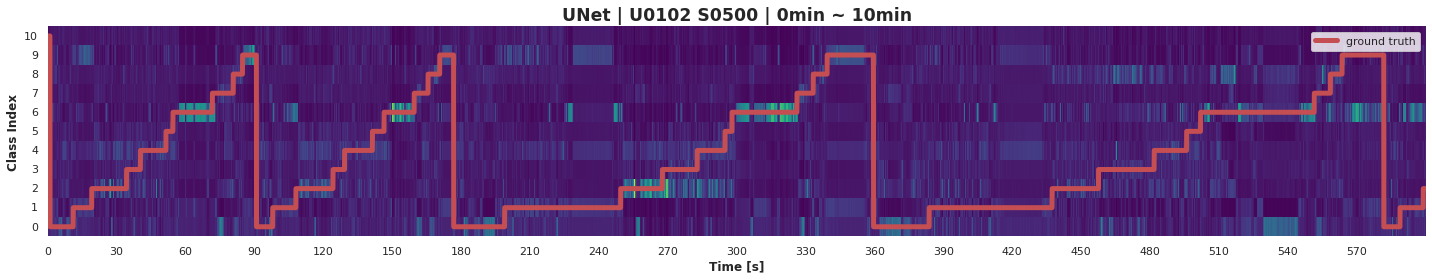

In [23]:
samples = (0, 10)

fig = plot_timeline(samples, t_idx, y_softmax, title_prefix=f"{cfg.model.name} | {user} {session}")
fig.show()

prob=(11, 18000) pred=(18000,), gt=(18000,)


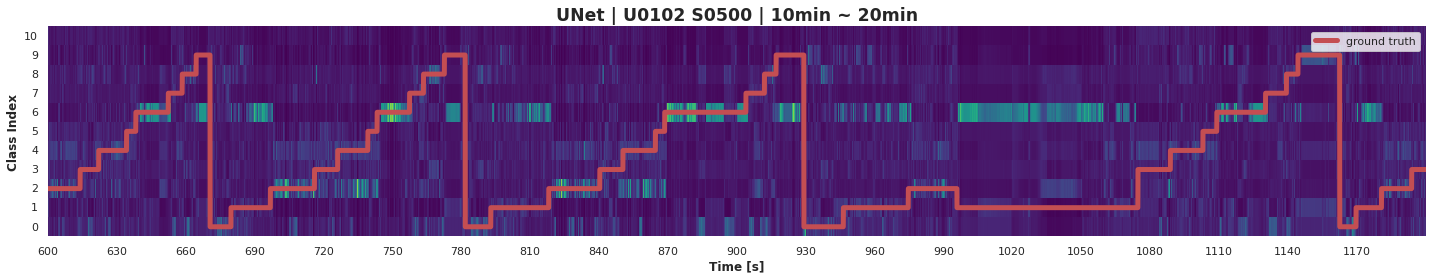

In [24]:
samples = (10, 20)

fig = plot_timeline(samples, t_idx, y_softmax, title_prefix=f"{cfg.model.name} | {user} {session}")
fig.show()

## [5] Submission

`optk.codalab.construct_submission_dict()` can be used to make submission files to codalab.
The parameter is almost the same as `optk.codalab.eval_operation_segmentation_wrapper()` (used for evaluation), but groundtruth field (`t_idx`) is exclided.

### 5-1: Get prediction for test data.

NOTE: Data for submission is not available in OpenPack(v0.2.0).  Therefore use test set for debugging purpose.

In [25]:
cfg.mode = "submission"
datamodule.setup("submission")
dataloaders = datamodule.submission_dataloader()
split = cfg.dataset.split.submission

outputs = dict()
for i, dataloader in enumerate(dataloaders):
    user, session = split[i]
    logger.info(f"test on {user}-{session}")

    trainer.test(plmodel, dataloader)

    # save model outputs
    pred_dir = Path(
        cfg.path.logdir.predict.format(user=user, session=session)
    )
    pred_dir.mkdir(parents=True, exist_ok=True)

    for key, arr in plmodel.test_results.items():
        path = Path(pred_dir, f"{key}.npy")
        np.save(path, arr)
        logger.info(f"save {key}[shape={arr.shape}] to {path}")

    outputs[f"{user}-{session}"] = {
        "y": plmodel.test_results.get("y"),
        "unixtime": plmodel.test_results.get("unixtime"),
    }

2022-09-28 22:26:15 | WARNING | openpack_torch.data.datasets | No preprocessing is applied.
2022-09-28 22:26:15 | INFO | openpack_torch.data.datamodule | dataset[train]: None
2022-09-28 22:26:15 | INFO | openpack_torch.data.datamodule | dataset[val]: None
2022-09-28 22:26:15 | INFO | openpack_torch.data.datamodule | dataset[test]: None
2022-09-28 22:26:15 | INFO | openpack_torch.data.datamodule | dataset[submission]: {'U0102-S0500': <openpack_torch.data.datasets.OpenPackImu object at 0x7fe65dd21970>}
2022-09-28 22:26:15 | INFO | __main__ | test on U0102-S0500
2022-09-28 22:26:15 | WARNING | openpack_torch.data.datasets | No preprocessing is applied.
2022-09-28 22:26:15 | INFO | openpack_torch.data.datamodule | dataset[train]: None
2022-09-28 22:26:15 | INFO | openpack_torch.data.datamodule | dataset[val]: None
2022-09-28 22:26:15 | INFO | openpack_torch.data.datamodule | dataset[test]: {'U0102-S0500': <openpack_torch.data.datasets.OpenPackImu object at 0x7fe65dd37670>}
2022-09-28 22:26

### 5-2: Make submission zip file

In the `construct_submission_dict()`, following processing will be done.

- Convert a predcition tesor `y` (3D array of logits) into a 2d matrix of predicted class ids.
- Resample sequence into 1 Hz.
- Exclude the segments that is out of range for the evaluation protocol (i.e., unlabeled or null segments).

In the `make_submission_zipfile()`, following processing will be done.

- extract `prediction` and `unixtime` field 
- generate `submission.json` and `submission.zip` to `output_dir`.

In [26]:
output_dir = str(cfg.path.logdir.rootdir)

submission_dict = construct_submission_dict(outputs, OPENPACK_OPERATIONS)
make_submission_zipfile(submission_dict, output_dir)

2022-09-28 22:26:15 | INFO | openpack_toolkit.codalab.operation_segmentation.utils | write submission.json to /content/logs/atr-acc-left-wrist/UNet/I01-EXP1-V1-nb/submission.json
2022-09-28 22:26:15 | INFO | openpack_toolkit.codalab.operation_segmentation.utils | write submission.zip to /content/logs/atr-acc-left-wrist/UNet/I01-EXP1-V1-nb/submission.zip


### 5-3: Submit to codalab and get results!

Now, you got a submission zip file (`./submission.zip`).
Let's upload it in the competition site (codalab) and get your score!

NOTE: If you are useing `optk.configs.datasets.splits.DEBUG_SPLIT` (default of this notebook), please use a submission form for "Development Phase".